# The Numerai data description

The Numerai data is divided into 3 subsets:
 - training data
 - validation data
 - live data
 
For training and validation data sets the target is known. The target information for live data is not provided. No one knows it (it is from the future). The goal of the competition is to predict target values for live data. Users predictions are used by Numerai to compute Meta Model (ensemble of all models from the competition). Numerai use Meta Model to submit positions to the market. Based on accuracy of user's prediction the rewards (payouts) are distributed to the participants in the Numerai token (Numeraire, ticker NMR). The reward depends on quality of predictions and stake value. The sake value is the amount of NMR the user is willing to bet on the predictions. Every week a new portion of live data is released. The users compute their predictions for live data and submit them to the Numerai service. The true target values are known for live data after 4 weeks from release and rewards are computed.  

The reward can be computed in two ways (user decide which will be used):
- reward based on correlation between predictions and targets on live data
- reward based on correlation between predictions and targets on live data and MMC contribution 

Three things that needs to be clarified:
- rewards are clipped on both side. The absolute correlation (or corr + MMC) value is clipped at 0.25.
- reward can be nagative if the correlation (or corr+MMC) is negative, then your stake will be decreased corresponding to the clipped correlation (or corr+MMC) value
- what is the MMC? The MMC is abbreviation for Meta Model Contribution. It is a metric that defines how much your predictions are important to the Numerai Meta Model.

## Why is it the hardest hardest data science tournament on the planet?

The number of possible solutions is **endless**. The goal of the user is to select such solution that will be the most profitable in the long run. It is hard because the signal to noise ratio is very small.

### How to do this?
You need to check as many as possible different solutions and select the best one (of few the best, because in the tournament you can stake on up to 10 models). In this tutorial I will show you how to create a set of solutions. Then select the models that will **minimize the risk** and **maximize the profit**. 

In [3]:
# load packages
import gc
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, uniform
from xgboost import XGBRegressor

## Load the data

In [4]:
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz").set_index("id", drop=True).astype("float16", errors="ignore")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz").set_index("id", drop=True).astype("float16", errors="ignore")
validation_data = tournament_data[tournament_data["data_type"] == "validation"]
del tournament_data
tournament_data = None
gc.collect()

feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

# Loading data...
Loaded 310 features


## Train models and collect predictions

In [154]:
# prepare data to 2 fold CV
era_list = training_data["era"].unique().tolist()
h1_eras = era_list[:len(era_list)//2]
h2_eras = era_list[len(era_list)//2:]

h1_data = training_data[training_data["era"].isin(h1_eras)]
h2_data = training_data[training_data["era"].isin(h2_eras)]

## Do a random search in the space of available models

In [162]:
np.random.seed(1776)

predictions = []
for i in range(300):
    name = f"Xgboost_{i}"
    max_depth = np.random.choice([2, 3, 4, 5])
    learning_rate = np.random.choice([0.001, 0.005, 0.01, 0.05, 0.1])
    n_estimators = np.random.choice([10, 50, 100, 200])
    colsample_bytree = np.random.choice([0.1, 0.2, 0.4, 0.7, 1.0])

    features = feature_names # default, use all features
    select_eras = era_list # default, use all eras
    if i == 0:
        print("Example Predictions")
        max_depth = 5
        learning_rate = 0.01
        n_estimators = 2000
        colsample_bytree = 0.1
    
    if i >= 100:
        print("Subsample columns")
        cols_count = np.random.randint(30, 270) # arbitrary numbers
        features = np.random.choice(feature_names, cols_count, replace=False)
        
    if i >= 200:
        print("Subsample eras")
        eras_count = np.random.randint(40, 110) # arbitrary numbers
        select_eras = np.random.choice(era_list, eras_count, replace=False)
        
    print(f"{name}, max_depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}, colsample_bytree={colsample_bytree}, eras count={len(select_eras)}, features count={len(features)}")

    model = XGBRegressor(max_depth=max_depth,
                         learning_rate=learning_rate,
                         n_estimators=n_estimators,
                         colsample_bytree=colsample_bytree,
                         n_jobs=12,
                         verbosity=1,
                         random_state=12)

    # train on fold 1
    model.fit(h1_data[features][h1_data["era"].isin(select_eras)], h1_data["target_kazutsugi"][h1_data["era"].isin(select_eras)])
    h2_preds = pd.Series(model.predict(h2_data[features]), index=h2_data.index)
    validation_preds_fold_1 = pd.Series(model.predict(validation_data[features]), index=validation_data.index)
    
    # train on fold 2
    model.fit(h2_data[features][h2_data["era"].isin(select_eras)], h2_data["target_kazutsugi"][h2_data["era"].isin(select_eras)])
    h1_preds = pd.Series(model.predict(h1_data[features]), index=h1_data.index)
    validation_preds_fold_2 = pd.Series(model.predict(validation_data[features]), index=validation_data.index)

    # train on all training data
    model.fit(training_data[features][training_data["era"].isin(select_eras)], training_data["target_kazutsugi"][training_data["era"].isin(select_eras)])
    validation_preds = pd.Series(model.predict(validation_data[features]), index=validation_data.index)

    predictions += [{
        "name": name,
        "training_preds": pd.concat([h1_preds, h2_preds]),
        "validation_preds_cv": (validation_preds_fold_1 + validation_preds_fold_2) / 2.0,
        "validation_preds": validation_preds,
    }]
    #pickle.dump(predictions, open("backup.pickle", "bw"))


Example Predictions
Xgboost_0, max_depth=5, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.1, eras count=120, features count=310
Xgboost_1, max_depth=2, learning_rate=0.01, n_estimators=100, colsample_bytree=1.0, eras count=120, features count=310
Xgboost_2, max_depth=5, learning_rate=0.1, n_estimators=200, colsample_bytree=0.4, eras count=120, features count=310
Xgboost_3, max_depth=5, learning_rate=0.005, n_estimators=50, colsample_bytree=0.1, eras count=120, features count=310
Xgboost_4, max_depth=4, learning_rate=0.1, n_estimators=10, colsample_bytree=0.2, eras count=120, features count=310
Xgboost_5, max_depth=4, learning_rate=0.01, n_estimators=200, colsample_bytree=0.2, eras count=120, features count=310
Xgboost_6, max_depth=3, learning_rate=0.005, n_estimators=10, colsample_bytree=0.1, eras count=120, features count=310
Xgboost_7, max_depth=5, learning_rate=0.001, n_estimators=50, colsample_bytree=0.7, eras count=120, features count=310
Xgboost_8, max_depth=5, learni

Xgboost_69, max_depth=4, learning_rate=0.005, n_estimators=50, colsample_bytree=1.0, eras count=120, features count=310
Xgboost_70, max_depth=3, learning_rate=0.1, n_estimators=200, colsample_bytree=0.1, eras count=120, features count=310
Xgboost_71, max_depth=4, learning_rate=0.1, n_estimators=10, colsample_bytree=0.4, eras count=120, features count=310
Xgboost_72, max_depth=2, learning_rate=0.05, n_estimators=50, colsample_bytree=0.4, eras count=120, features count=310
Xgboost_73, max_depth=4, learning_rate=0.005, n_estimators=100, colsample_bytree=1.0, eras count=120, features count=310
Xgboost_74, max_depth=4, learning_rate=0.1, n_estimators=50, colsample_bytree=0.1, eras count=120, features count=310
Xgboost_75, max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=1.0, eras count=120, features count=310
Xgboost_76, max_depth=4, learning_rate=0.005, n_estimators=200, colsample_bytree=1.0, eras count=120, features count=310
Xgboost_77, max_depth=2, learning_rate=0.01, n

Subsample columns
Xgboost_133, max_depth=2, learning_rate=0.01, n_estimators=10, colsample_bytree=1.0, eras count=120, features count=110
Subsample columns
Xgboost_134, max_depth=3, learning_rate=0.01, n_estimators=100, colsample_bytree=0.4, eras count=120, features count=195
Subsample columns
Xgboost_135, max_depth=2, learning_rate=0.01, n_estimators=200, colsample_bytree=0.4, eras count=120, features count=264
Subsample columns
Xgboost_136, max_depth=3, learning_rate=0.001, n_estimators=50, colsample_bytree=0.4, eras count=120, features count=247
Subsample columns
Xgboost_137, max_depth=4, learning_rate=0.05, n_estimators=50, colsample_bytree=0.2, eras count=120, features count=210
Subsample columns
Xgboost_138, max_depth=4, learning_rate=0.01, n_estimators=200, colsample_bytree=1.0, eras count=120, features count=217
Subsample columns
Xgboost_139, max_depth=5, learning_rate=0.001, n_estimators=10, colsample_bytree=0.1, eras count=120, features count=89
Subsample columns
Xgboost_140,

Subsample columns
Xgboost_193, max_depth=2, learning_rate=0.005, n_estimators=10, colsample_bytree=0.4, eras count=120, features count=97
Subsample columns
Xgboost_194, max_depth=5, learning_rate=0.01, n_estimators=10, colsample_bytree=0.4, eras count=120, features count=232
Subsample columns
Xgboost_195, max_depth=5, learning_rate=0.01, n_estimators=50, colsample_bytree=0.4, eras count=120, features count=66
Subsample columns
Xgboost_196, max_depth=5, learning_rate=0.01, n_estimators=200, colsample_bytree=0.1, eras count=120, features count=258
Subsample columns
Xgboost_197, max_depth=4, learning_rate=0.005, n_estimators=200, colsample_bytree=0.2, eras count=120, features count=79
Subsample columns
Xgboost_198, max_depth=3, learning_rate=0.005, n_estimators=10, colsample_bytree=0.7, eras count=120, features count=235
Subsample columns
Xgboost_199, max_depth=4, learning_rate=0.05, n_estimators=50, colsample_bytree=0.1, eras count=120, features count=95
Subsample columns
Subsample eras


Subsample columns
Subsample eras
Xgboost_248, max_depth=5, learning_rate=0.005, n_estimators=200, colsample_bytree=1.0, eras count=90, features count=130
Subsample columns
Subsample eras
Xgboost_249, max_depth=4, learning_rate=0.05, n_estimators=10, colsample_bytree=1.0, eras count=103, features count=204
Subsample columns
Subsample eras
Xgboost_250, max_depth=5, learning_rate=0.005, n_estimators=50, colsample_bytree=0.7, eras count=77, features count=170
Subsample columns
Subsample eras
Xgboost_251, max_depth=3, learning_rate=0.05, n_estimators=50, colsample_bytree=0.7, eras count=104, features count=209
Subsample columns
Subsample eras
Xgboost_252, max_depth=3, learning_rate=0.005, n_estimators=10, colsample_bytree=1.0, eras count=102, features count=188
Subsample columns
Subsample eras
Xgboost_253, max_depth=4, learning_rate=0.001, n_estimators=200, colsample_bytree=0.1, eras count=65, features count=174
Subsample columns
Subsample eras
Xgboost_254, max_depth=5, learning_rate=0.001,

## Prepare predictions Data Frames

In [163]:
training_preds_df = pd.DataFrame()
validation_preds_cv_df = pd.DataFrame()
validation_preds_df = pd.DataFrame()

In [164]:
for pred in predictions:
    training_preds_df[pred["name"]] = pred["training_preds"]
    validation_preds_cv_df[pred["name"]] = pred["validation_preds_cv"]
    validation_preds_df[pred["name"]] = pred["validation_preds"]

In [165]:
training_preds_df["era"] = training_data["era"]
validation_preds_cv_df["era"] = validation_data["era"]
validation_preds_df["era"] = validation_data["era"]

In [166]:
training_preds_df["target"] = training_data["target_kazutsugi"]
validation_preds_cv_df["target"] = validation_data["target_kazutsugi"]
validation_preds_df["target"] = validation_data["target_kazutsugi"]

In [167]:
# save them
training_preds_df.to_csv("training_preds.csv")
validation_preds_cv_df.to_csv("validation_preds_cv.csv")
validation_preds_df.to_csv("validation_preds.csv")

## Compute Scores per Era

In [168]:
model_names = [c for c in validation_preds_df if "era" != c and "target" != c]

In [169]:
val_scores_per_era = validation_preds_df.groupby("era").apply(lambda d: d[model_names].corrwith(d["target"], method="spearman"))

In [170]:
training_scores_per_era = training_preds_df.groupby("era").apply(lambda d: d[model_names].corrwith(d["target"], method="spearman"))

## Overall Metrics

In [171]:
metrics_df = pd.DataFrame(index=model_names, columns=[])

In [172]:
# Calculate mean
metrics_df["val_mean"] = val_scores_per_era.mean()
metrics_df["training_mean"] = training_scores_per_era.mean()
# Calcualte sharpe
metrics_df["val_sharpe"] = val_scores_per_era.mean()/val_scores_per_era.std()
metrics_df["training_sharpe"] = training_scores_per_era.mean()/training_scores_per_era.std()

In [173]:
metrics_df

,val_mean,training_mean,val_sharpe,training_sharpe
Xgboost_0,0.029522,0.048693,0.968562,1.437529
Xgboost_1,0.013360,0.029392,0.450310,0.884996
Xgboost_2,0.028196,0.042737,1.052106,1.407838
Xgboost_3,0.021138,0.040879,0.658913,1.197442
Xgboost_4,0.018272,0.034420,0.619255,1.038710
...,...,...,...,...
Xgboost_295,0.021939,0.039663,0.721738,1.259772
Xgboost_296,0.019951,0.026796,0.734083,1.013394
Xgboost_297,0.016138,0.027687,0.598796,1.000158
Xgboost_298,0.016958,0.030894,0.584518,0.922352


## Feature Neutrality

In [174]:
training_full_df = pd.concat([training_preds_df, training_data[feature_names]], axis=1)
training_full_df = training_full_df.loc[:,~training_full_df.columns.duplicated()]

val_full_df = pd.concat([validation_preds_df, validation_data[feature_names]], axis=1)
val_full_df = val_full_df.loc[:,~val_full_df.columns.duplicated()]

In [175]:
def neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()

In [176]:
# This part will take 10+ minutes
val_feature_neutral_means = {}
for model in model_names:
    model_preds = validation_preds_df[model]
    val_full_df["neutral_"+model] = neutralize(val_full_df, [model], feature_names)[model]
    val_feature_neutral_means[model] = val_full_df.groupby("era").apply(lambda x: spearmanr(x["neutral_"+model], x["target"])[0]).mean()
metrics_df["val_feature_neutral_mean"] = pd.Series(val_feature_neutral_means)

In [177]:
# This part will take 10+ minutes
training_feature_neutral_means = {}
for model in model_names:
    model_preds = training_preds_df[model]
    training_full_df["neutral_"+model] = neutralize(training_full_df, [model], feature_names)[model]
    training_feature_neutral_means[model] = training_full_df.groupby("era").apply(lambda x: spearmanr(x["neutral_"+model], x["target"])[0]).mean()
metrics_df["training_feature_neutral_mean"] = pd.Series(training_feature_neutral_means)

In [178]:
# max feature exposure
# takes awhile to run
val_max_feature_exposures = {}
val_square_sum_feature_exposures = {}
for model in model_names:
    exposures = []
    for feature in feature_names:
        exposures.append(spearmanr(val_full_df[model], val_full_df[feature])[0])
    val_max_feature_exposures[model] = np.max(np.abs(exposures))
    val_square_sum_feature_exposures[model] = np.sum([e**2 for e in exposures])
metrics_df["val_max_feature_exposure"] = pd.Series(val_max_feature_exposures)
metrics_df["val_square_sum_feature_exposure"] = pd.Series(val_square_sum_feature_exposures)

# max feature exposure
# takes quite awhile to run
training_max_feature_exposures = {}
training_square_sum_feature_exposures = {}
for model in model_names:
    exposures = []
    for feature in feature_names:
        exposures.append(spearmanr(training_full_df[model], training_full_df[feature])[0])
    training_max_feature_exposures[model] = np.max(np.abs(exposures))
    training_square_sum_feature_exposures[model] = np.sum([e**2 for e in exposures])
metrics_df["training_max_feature_exposure"] = pd.Series(training_max_feature_exposures)
metrics_df["training_square_sum_feature_exposure"] = pd.Series(training_square_sum_feature_exposures)

/home/piotr/Downloads/numerai_datasets/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [180]:
metrics_df.to_csv("metrics_df.csv")

In [181]:
## Risk

In [188]:
validation_vars = {}
for model in model_names:
    validation_vars[model] = val_scores_per_era[model].std()
metrics_df["val_var"] = pd.Series(validation_vars)

training_vars = {}
for model in model_names:
    training_vars[model] = training_scores_per_era[model].std()
metrics_df["training_var"] = pd.Series(training_vars)

In [192]:
val_scores_per_era

,Xgboost_0,Xgboost_1,Xgboost_2,Xgboost_3,Xgboost_4,Xgboost_5,Xgboost_6,Xgboost_7,Xgboost_8,Xgboost_9,Xgboost_10,Xgboost_11,Xgboost_12,Xgboost_13,Xgboost_14,Xgboost_15,Xgboost_16,Xgboost_17,Xgboost_18,Xgboost_19,Xgboost_20,Xgboost_21,Xgboost_22,Xgboost_23,Xgboost_24,Xgboost_25,Xgboost_26,Xgboost_27,Xgboost_28,Xgboost_29,Xgboost_30,Xgboost_31,Xgboost_32,Xgboost_33,Xgboost_34,Xgboost_35,Xgboost_36,Xgboost_37,Xgboost_38,Xgboost_39,Xgboost_40,Xgboost_41,Xgboost_42,Xgboost_43,Xgboost_44,Xgboost_45,Xgboost_46,Xgboost_47,Xgboost_48,Xgboost_49,Xgboost_50,Xgboost_51,Xgboost_52,Xgboost_53,Xgboost_54,Xgboost_55,Xgboost_56,Xgboost_57,Xgboost_58,Xgboost_59,Xgboost_60,Xgboost_61,Xgboost_62,Xgboost_63,Xgboost_64,Xgboost_65,Xgboost_66,Xgboost_67,Xgboost_68,Xgboost_69,Xgboost_70,Xgboost_71,Xgboost_72,Xgboost_73,Xgboost_74,Xgboost_75,Xgboost_76,Xgboost_77,Xgboost_78,Xgboost_79,Xgboost_80,Xgboost_81,Xgboost_82,Xgboost_83,Xgboost_84,Xgboost_85,Xgboost_86,Xgboost_87,Xgboost_88,Xgboost_89,Xgboost_90,Xgboost_91,Xgboost_92,Xgboost_93,Xgboost_94,Xgboost_95,Xgboost_96,Xgboost_97,Xgboost_98,Xgboost_99,Xgboost_100,Xgboost_101,Xgboost_102,Xgboost_103,Xgboost_104,Xgboost_105,...,Xgboost_194,Xgboost_195,Xgboost_196,Xgboost_197,Xgboost_198,Xgboost_199,Xgboost_200,Xgboost_201,Xgboost_202,Xgboost_203,Xgboost_204,Xgboost_205,Xgboost_206,Xgboost_207,Xgboost_208,Xgboost_209,Xgboost_210,Xgboost_211,Xgboost_212,Xgboost_213,Xgboost_214,Xgboost_215,Xgboost_216,Xgboost_217,Xgboost_218,Xgboost_219,Xgboost_220,Xgboost_221,Xgboost_222,Xgboost_223,Xgboost_224,Xgboost_225,Xgboost_226,Xgboost_227,Xgboost_228,Xgboost_229,Xgboost_230,Xgboost_231,Xgboost_232,Xgboost_233,Xgboost_234,Xgboost_235,Xgboost_236,Xgboost_237,Xgboost_238,Xgboost_239,Xgboost_240,Xgboost_241,Xgboost_242,Xgboost_243,Xgboost_244,Xgboost_245,Xgboost_246,Xgboost_247,Xgboost_248,Xgboost_249,Xgboost_250,Xgboost_251,Xgboost_252,Xgboost_253,Xgboost_254,Xgboost_255,Xgboost_256,Xgboost_257,Xgboost_258,Xgboost_259,Xgboost_260,Xgboost_261,Xgboost_262,Xgboost_263,Xgboost_264,Xgboost_265,Xgboost_266,Xgboost_267,Xgboost_268,Xgboost_269,Xgboost_270,Xgboost_271,Xgboost_272,Xgboost_273,Xgboost_274,Xgboost_275,Xgboost_276,Xgboost_277,Xgboost_278,Xgboost_279,Xgboost_280,Xgboost_281,Xgboost_282,Xgboost_283,Xgboost_284,Xgboost_285,Xgboost_286,Xgboost_287,Xgboost_288,Xgboost_289,Xgboost_290,Xgboost_291,Xgboost_292,Xgboost_293,Xgboost_294,Xgboost_295,Xgboost_296,Xgboost_297,Xgboost_298,Xgboost_299
era,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
era121,0.026357,-0.012398,0.022932,0.019248,0.016073,0.013117,0.010741,0.000567,0.012428,0.011165,-0.011631,0.016035,0.006265,-0.001508,0.003358,0.001413,0.002229,0.011819,-0.006372,0.015704,-0.019195,-0.010601,-0.002217,-0.012453,0.000567,-0.018197,-0.010605,0.007223,-0.007518,0.016231,0.007974,0.007974,0.014281,-0.017378,0.007647,0.003061,0.004613,0.021540,0.008291,0.003457,0.009649,0.012428,-0.007852,0.014848,0.010689,0.018413,0.019593,0.020827,0.010689,-0.021831,0.002480,-0.017266,-0.000730,0.001950,-0.004014,0.007223,0.008339,0.017380,-0.005693,-0.011163,0.002646,-0.013605,-0.025535,-0.002119,0.003355,0.006265,0.009866,0.018413,0.003452,-0.003606,0.015321,-0.003987,-0.007725,-0.003309,0.010455,0.011013,0.001950,-0.007852,0.017960,-0.031760,-0.016339,0.018458,0.016228,-0.004244,-0.015204,0.018009,0.003452,0.020882,-0.007970,0.003641,0.008448,0.003358,-0.001163,0.008047,0.012133,-0.008860,0.017363,0.008764,0.012331,0.016731,0.009127,-0.015285,-0.001452,-0.010018,0.048605,-0.018705,...,0.007114,0.017576,0.027893,0.012626,0.011501,0.034503,-0.010781,0.002071,0.025847,0.011824,0.001756,0.039162,0.002838,0.028394,0.024676,-0.011736,0.022919,-0.029445,-0.010821,-0.004182,-0.014203,0.004745,0.014709,0.038277,0.017774,-0.011149,0.009121,0.021773,-0.003520,0.007566,0.018369,0.019571,0.022768,0.010905,-0.001653,0.023653,0.026761

In [193]:
model = "Xgboost_0"

In [198]:
(val_scores_per_era[model]+1).cumprod().rolling(window=100, min_periods=1).max()

era
era121    1.026357
era122    1.074948
era123    1.127400
era124    1.203525
era125    1.246724
era126    1.274437
era127    1.274437
era128    1.364593
era129    1.364593
era130    1.445559
era131    1.513100
era132    1.629264
era197    1.682201
era198    1.725074
era199    1.725074
era200    1.725074
era201    1.725074
era202    1.761891
era203    1.816450
era204    1.908057
era205    1.908057
era206    1.908057
Name: Xgboost_0, dtype: float64

In [199]:
(val_scores_per_era[model]+1).cumprod()

era
era121    1.026357
era122    1.074948
era123    1.127400
era124    1.203525
era125    1.246724
era126    1.274437
era127    1.270014
era128    1.364593
era129    1.364375
era130    1.445559
era131    1.513100
era132    1.629264
era197    1.682201
era198    1.725074
era199    1.646126
era200    1.679489
era201    1.686671
era202    1.761891
era203    1.816450
era204    1.908057
era205    1.888453
era206    1.879071
Name: Xgboost_0, dtype: float64

In [200]:
val_scores_per_era[model]

era
era121    0.026357
era122    0.047343
era123    0.048795
era124    0.067522
era125    0.035894
era126    0.022228
era127   -0.003470
era128    0.074471
era129   -0.000160
era130    0.059503
era131    0.046723
era132    0.076772
era197    0.032491
era198    0.025486
era199   -0.045765
era200    0.020268
era201    0.004276
era202    0.044597
era203    0.030967
era204    0.050432
era205   -0.010274
era206   -0.004968
Name: Xgboost_0, dtype: float64

In [203]:
rolling_max = (val_scores_per_era[model]+1).cumprod().rolling(window=100, min_periods=1).max()
daily_value = (val_scores_per_era[model]+1).cumprod()

In [204]:
rolling_max

era
era121    1.026357
era122    1.074948
era123    1.127400
era124    1.203525
era125    1.246724
era126    1.274437
era127    1.274437
era128    1.364593
era129    1.364593
era130    1.445559
era131    1.513100
era132    1.629264
era197    1.682201
era198    1.725074
era199    1.725074
era200    1.725074
era201    1.725074
era202    1.761891
era203    1.816450
era204    1.908057
era205    1.908057
era206    1.908057
Name: Xgboost_0, dtype: float64

In [205]:
daily_value

era
era121    1.026357
era122    1.074948
era123    1.127400
era124    1.203525
era125    1.246724
era126    1.274437
era127    1.270014
era128    1.364593
era129    1.364375
era130    1.445559
era131    1.513100
era132    1.629264
era197    1.682201
era198    1.725074
era199    1.646126
era200    1.679489
era201    1.686671
era202    1.761891
era203    1.816450
era204    1.908057
era205    1.888453
era206    1.879071
Name: Xgboost_0, dtype: float64

In [206]:
(rolling_max - daily_value).max()

0.07894746691648002

In [183]:
# max drawdown
val_max_drawdown = {}
for model in model_names:
    rolling_max = (val_scores_per_era[model]+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (val_scores_per_era[model]+1).cumprod()
    val_max_drawdown[model] = (rolling_max - daily_value).max()
metrics_df["val_max_drawdown"] = pd.Series(val_max_drawdown)

# max drawdown
training_max_drawdown = {}
for model in model_names:
    rolling_max = (training_scores_per_era[model]+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (training_scores_per_era[model]+1).cumprod()
    training_max_drawdown[model] = (rolling_max - daily_value).max()
metrics_df["training_max_drawdown"] = pd.Series(training_max_drawdown)

In [184]:
##  MMC

In [186]:
import warnings
warnings.filterwarnings("ignore") # this is bad but we hate all the deprecation warnings from scipy
# MMC over validation
def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
       (exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
       np.linalg.lstsq(exposures, scores)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized

def unif(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return uniform.ppf(X)

mmc_means = {}
mmc_stds = {}
mmc_sharpes = {}
corr_plus_mmc_sharpes = {}

for model in model_names:
    # neutralize user to example preds
    user_mmc_scores = []
    user_corr_scores = []
    for era, x in validation_preds_df.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[model])), pd.Series(unif(x["Xgboost_0"])))
        user_mmc_scores.append(np.cov(series, x["target"])[0,1]/0.29**2)
        user_corr_scores.append(spearmanr(unif(x[model]), unif(x["target"]))[0])
    mmc_mean = np.mean(user_mmc_scores)
    mmc_std = np.std(user_mmc_scores)
    mmc_sharpe = mmc_mean/mmc_std
    mmc_means[model] = mmc_mean
    mmc_stds[model] = mmc_stds
    mmc_sharpes[model] = mmc_sharpe
    corr_plus_mmcs = [c+m for c,m in zip(user_corr_scores, user_mmc_scores)]
    corr_plus_mmc_sharpes[model] = np.mean(corr_plus_mmcs)/np.std(corr_plus_mmcs)
    
metrics_df["val_mmc_mean"] = pd.Series(mmc_means)
metrics_df["val_mmc_sharpe"] = pd.Series(mmc_sharpes)
metrics_df["val_corr_plus_mmc_sharpe"] = pd.Series(corr_plus_mmc_sharpes)


training_mmc_means = {}
training_mmc_stds = {}
training_mmc_sharpes = {}
training_corr_plus_mmc_sharpes = {}

for model in model_names:
    # neutralize user to example preds
    user_mmc_scores = []
    user_corr_scores = []
    for era, x in training_preds_df.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[model])), pd.Series(unif(x["Xgboost_0"])))
        user_mmc_scores.append(np.cov(series, x["target"])[0,1]/0.29**2)
        user_corr_scores.append(spearmanr(unif(x[model]), unif(x["target"]))[0])
    mmc_mean = np.mean(user_mmc_scores)
    mmc_std = np.std(user_mmc_scores)
    mmc_sharpe = mmc_mean/mmc_std
    training_mmc_means[model] = mmc_mean
    training_mmc_stds[model] = mmc_stds
    training_mmc_sharpes[model] = mmc_sharpe
    corr_plus_mmcs = [c+m for c,m in zip(user_corr_scores, user_mmc_scores)]
    training_corr_plus_mmc_sharpes[model] = np.mean(corr_plus_mmcs)/np.std(corr_plus_mmcs)
    
metrics_df["training_mmc_mean"] = pd.Series(training_mmc_means)
metrics_df["training_mmc_sharpe"] = pd.Series(training_mmc_sharpes)
metrics_df["training_corr_plus_mmc_sharpe"] = pd.Series(training_corr_plus_mmc_sharpes)

In [208]:
metrics_df

,val_mean,training_mean,val_sharpe,training_sharpe,val_feature_neutral_mean,training_feature_neutral_mean,val_max_feature_exposure,val_square_sum_feature_exposure,training_max_feature_exposure,training_square_sum_feature_exposure,val_var,training_var,val_max_drawdown,training_max_drawdown,val_mmc_mean,val_mmc_sharpe,val_corr_plus_mmc_sharpe,training_mmc_mean,training_mmc_sharpe,training_corr_plus_mmc_sharpe
Xgboost_0,0.029522,0.048693,0.968562,1.437529,0.026596,0.016955,0.296916,2.209518,0.293729,1.973702,0.030480,0.033873,0.078947,5.545741,-5.943477e-18,-0.493515,0.993162,2.612157e-18,0.083337,1.465951
Xgboost_1,0.013360,0.029392,0.450310,0.884996,0.007386,0.004742,0.468288,1.997761,0.413671,2.058831,0.029668,0.033211,0.056099,1.126540,-4.937152e-03,-0.220332,0.167627,7.240924e-04,0.033965,0.576617
Xgboost_2,0.028196,0.042737,1.052106,1.407838,0.022616,0.014898,0.269724,1.657227,0.263457,1.340765,0.026799,0.030357,0.046310,2.884214,2.968528e-03,0.369350,1.124564,2.726344e-03,0.244443,1.271761
Xgboost_3,0.021138,0.040879,0.658913,1.197442,0.013908,0.011565,0.331526,4.161023,0.263436,4.328011,0.032080,0.034139,0.074587,3.965935,-2.402742e-03,-0.145740,0.407278,4.537546e-03,0.248218,0.935197
Xgboost_4,0.018272,0.034420,0.619255,1.038710,0.011375,0.007295,0.317842,2.641794,0.298287,2.691443,0.029507,0.033137,0.058358,1.690673,-2.671443e-03,-0.174271,0.357958,2.101542e-03,0.110871,0.741193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xgboost_295,0.021939,0.039663,0.721738,1.259772,0.019340,0.011917,0.299289,4.674664,0.267392,4.263505,0.030397,0.031485,0.080739,2.296211,-1.228499e-03,-0.071479,0.472818,5.017139e-03,0.280610,0.989519
Xgboost_296,0.019951,0.026796,0.734083,1.013394,0.010294,0.001044,0.413418,8.097153,0.373104,7.381044,0.027178,0.026442,0.035348,0.705088,5.967896e-03,0.240868,0.508571,6.972442e-03,0.291767,0.708097
Xgboost_297,0.016138,0.027687,0.598796,1.000158,0.010989,0.004720,0.359251,6.270562,0.366275,6.169876,0.026950,0.027683,0.083527,1.015040,8.482065e-04,0.037124,0.354871,5.051690e-03,0.222012,0.685923
Xgboost_298,0.016958,0.030894,0.584518,0.922352,0.011574,0.001545,0.355170,6.271968,0.306544,5.512996,0.029013,0.033495,0.097730,1.589142,-2.238945e-03,-0.132510,0.336092,1.401777e-03,0.062451,0.598388


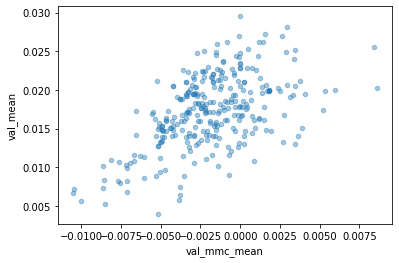

In [215]:
metrics_df.plot(x="val_mmc_mean", y="val_mean", kind="scatter", alpha=0.4)

In [ ]:
metrics_df[1:].plot(x="val_corr_plus_mmc_sharpe", y="training_corr_plus_mmc_sharpe", kind="scatter", alpha=0.4)

In [214]:
metrics_df["val_mmc_mean"][0:]

Xgboost_0     -5.943477e-18
Xgboost_1     -4.937152e-03
Xgboost_2      2.968528e-03
Xgboost_3     -2.402742e-03
Xgboost_4     -2.671443e-03
                   ...     
Xgboost_295   -1.228499e-03
Xgboost_296    5.967896e-03
Xgboost_297    8.482065e-04
Xgboost_298   -2.238945e-03
Xgboost_299   -6.280918e-03
Name: val_mmc_mean, Length: 300, dtype: float64

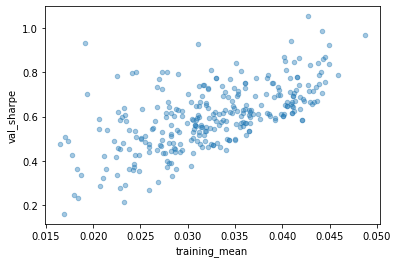

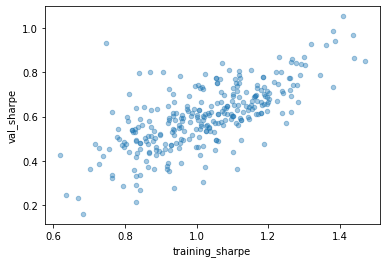

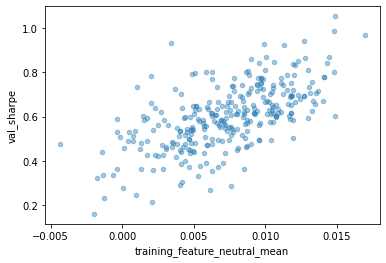

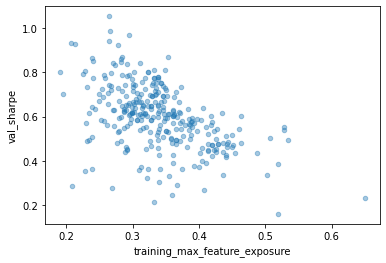

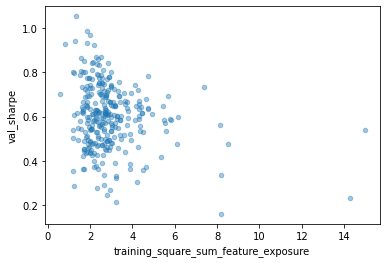

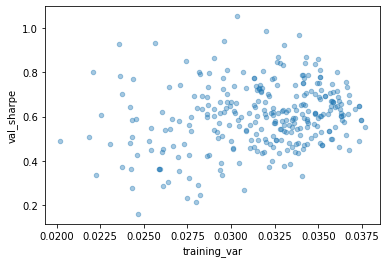

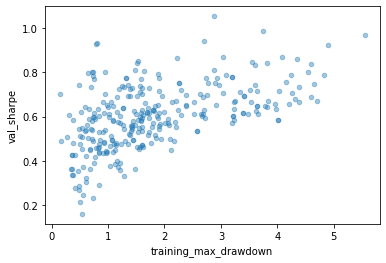

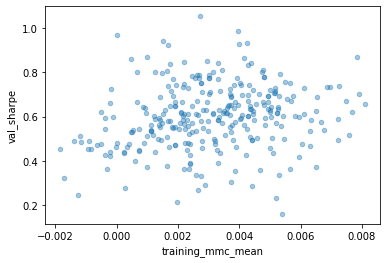

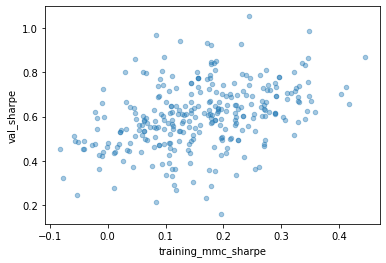

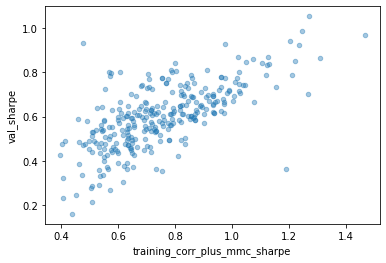

In [187]:
for metric in metrics_df.columns:
    # we just want to see how well our training cross-validated metrics correspond to out-of sample (validation) returns
    if "train" in metric:
        metrics_df.plot(x=metric, y="val_sharpe", kind="scatter", alpha=0.4)